In [1]:
import pandas as pd
import datetime as dt
import time
import requests
import regex as re
import numpy as np
import requests
import re
from nltk.tokenize import RegexpTokenizer

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords 
from bs4 import BeautifulSoup  
%matplotlib inline
import string
from nltk.corpus import stopwords
stop_words = stopwords.words('english')







In [2]:
#import data

df = pd.read_csv("./Amazon.csv")
df.head(2)

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,imageURLs,...,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,upc,weight
0,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,5.0,http://reviews.bestbuy.com/3545/4562009/review...,"This keyboard is very easy to type on, but the...",Love the fingerprint reader,JNH1,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
1,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,...,True,0.0,4.0,http://reviews.bestbuy.com/3545/4562009/review...,It's thin and light. I can type pretty easily ...,Nice,Appa,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds


In [3]:
df.shape

(7299, 27)

In [4]:
#Data cleaning

In [5]:
df.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'dimension', 'ean', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'primaryCategories', 'reviews.date',
       'reviews.dateSeen', 'reviews.doRecommend', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.username', 'sourceURLs', 'upc', 'weight'],
      dtype='object')

In [6]:
# drop columns

df = df.drop(['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'dimension', 'ean', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'primaryCategories', 'reviews.date',
       'reviews.dateSeen', 'reviews.doRecommend', 'reviews.numHelpful',
        'reviews.sourceURLs',
     'sourceURLs', 'upc', 'weight'], axis=1)


In [7]:
df.head(5)

,reviews.rating,reviews.text,reviews.title,reviews.username
0,5.0,"This keyboard is very easy to type on, but the...",Love the fingerprint reader,JNH1
1,4.0,It's thin and light. I can type pretty easily ...,Nice,Appa
2,4.0,I love the new design the keys are spaced well...,New,Kman
3,5.0,Attached easily and firmly. Has a nice feel. A...,Nice keyboard,UpstateNY
4,5.0,"Our original keyboard was okay, but did not ha...",Nice improvement,Glickster


In [8]:
df.isnull().sum()

reviews.rating      164
reviews.text          5
reviews.title         4
reviews.username      0
dtype: int64

In [9]:
df = df.dropna()

In [10]:
df.isnull().sum()

reviews.rating      0
reviews.text        0
reviews.title       0
reviews.username    0
dtype: int64

In [11]:
df.shape

(7126, 4)

In [12]:
df['reviews.rating'].value_counts()

5.0    4487
4.0    1659
3.0     440
1.0     318
2.0     222
Name: reviews.rating, dtype: int64

Text(0.5, 1.0, 'Ratings')

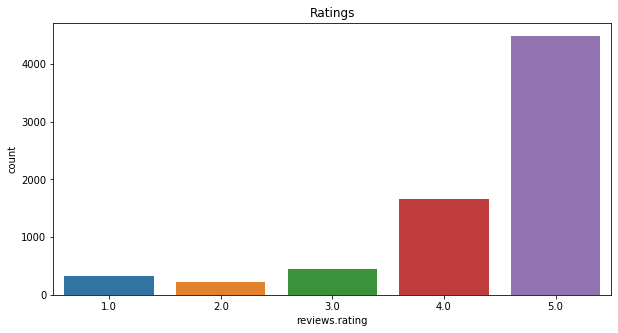

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(df['reviews.rating'])
plt.title('Ratings')

In [14]:
# remove rows with duplicated author to have well distributed opinions
df.drop_duplicates(subset='reviews.username',inplace=True)

In [15]:
df.shape

(6377, 4)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6377 entries, 0 to 7298
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   reviews.rating    6377 non-null   float64
 1   reviews.text      6377 non-null   object 
 2   reviews.title     6377 non-null   object 
 3   reviews.username  6377 non-null   object 
dtypes: float64(1), object(3)
memory usage: 249.1+ KB


In [17]:
df['alltext'] = df['reviews.title'] + df['reviews.text']

In [18]:
df['feedback'] = df['reviews.rating']>=4
#1 in feedback is postive and zero is negative

In [19]:
#df['feedback'] = df['feedback'].replace([1, 0] , ['positive' , 'negative'])

In [20]:
df.head(3)

,reviews.rating,reviews.text,reviews.title,reviews.username,alltext,feedback
0,5.0,"This keyboard is very easy to type on, but the...",Love the fingerprint reader,JNH1,Love the fingerprint readerThis keyboard is ve...,True
1,4.0,It's thin and light. I can type pretty easily ...,Nice,Appa,NiceIt's thin and light. I can type pretty eas...,True
2,4.0,I love the new design the keys are spaced well...,New,Kman,NewI love the new design the keys are spaced w...,True


In [21]:
df['feedback'].value_counts()

True     5508
False     869
Name: feedback, dtype: int64

In [22]:

# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(df[['alltext']],
                                                    df['feedback'],
                                                    test_size = 0.25,
                                                    random_state = 42)

In [23]:
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
  

    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    stops.update(list(string.punctuation))
    words_add = ['zip', 'zimmer', 'zipper', 'zippers', 'zipping', 'zips', 'zone', 'zoom', 'zr', 'zvox', 'zx', 'aaa', 'aas', 'ab']
    stops.update(list(words_add))
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [24]:
df['clean_text'] =  df.alltext.map(review_to_words)

In [25]:
df['clean_text']

0       love fingerprint readerthis keyboard easy type...
1                    niceit thin light type pretty easily
2       newi love new design keys spaced well mis type...
3       nice keyboardattached easily firmly nice feel ...
4       nice improvementour original keyboard okay lap...
                              ...                        
7288    pretty sophisticated control devicei still try...
7295    good productthis looks good celling flushes we...
7296    great plategreat plate projector mount easy in...
7297    great mount works well adjustable columnthis m...
7298    mount plateit nice solid mounting plate check ...
Name: clean_text, Length: 6377, dtype: object

In [26]:
# Get the number of reviews based on the dataframe size.
total_reviews = df.shape[0]
print(f'There are {total_reviews} reviews.')

# Initialize an empty list to hold the clean reviews.
clean_train_reviews = []
clean_test_reviews = []

There are 6377 reviews.


In [27]:
# Initialize an empty list to hold the clean reviews.
clean_train_reviews = []
clean_test_reviews = []

print("Cleaning and parsing the training set movie reviews...")

# Instantiate counter.
j = 0

# For every review in our training set...
for train_review in X_train['alltext']:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_train_reviews.append(review_to_words(train_review))
    
    # If the index is divisible by 300, print a message.
    if (j + 1) % 300 == 0:
        print(f'Review {j + 1} of {total_reviews}.')
    
    j += 1

# Let's do the same for our testing set.
print("Cleaning and parsing the testing set movie reviews...")

# For every review in our testing set...
for test_review in X_test['alltext']:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_test_reviews.append(review_to_words(test_review))
    
    # If the index is divisible by 300, print a message.
    if (j + 1) % 300 == 0:
        print(f'Review {j + 1} of {total_reviews}.')
        
    j += 1

Cleaning and parsing the training set movie reviews...
Review 300 of 6377.
Review 600 of 6377.
Review 900 of 6377.
Review 1200 of 6377.
Review 1500 of 6377.
Review 1800 of 6377.
Review 2100 of 6377.
Review 2400 of 6377.
Review 2700 of 6377.
Review 3000 of 6377.
Review 3300 of 6377.
Review 3600 of 6377.
Review 3900 of 6377.
Review 4200 of 6377.
Review 4500 of 6377.
Cleaning and parsing the testing set movie reviews...
Review 4800 of 6377.
Review 5100 of 6377.
Review 5400 of 6377.
Review 5700 of 6377.
Review 6000 of 6377.
Review 6300 of 6377.


In [28]:
clean_train_reviews

['good compared older models annoyingthis rd harmony remote bought last harmony one broken display using years therefore review based comparison last remotes used first thing noticed remote lighter ones also order upload configuration needed download new myharmony software instead older software good thing able migrate configuration harmony one however migration configuration perfectly place example buttons working anymore needed manually configure perfect remote based touchscreen display trying get used since harmony one analog buttons one disavantages think used feel buttons never look needed press anything remote need look display every time need change channels however include favorite channels main screen makes sense since noticed usually watch half dozen channels newbie harmony remote may find difficulties programming since already owned previous model think good remote little worse older models',
 'portable tvworks fairly well replacement real think many ad',
 'easy setup use ab

In [29]:
# Import CountVectorizer.
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate the "CountVectorizer" object, which is sklearn's
# bag of words tool.
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000) 

In [30]:
# fit_transform() does two things: First, it fits the model and 
# learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a 
# list of strings.

train_data_features = vectorizer.fit_transform(clean_train_reviews)

test_data_features = vectorizer.transform(clean_test_reviews)

In [31]:
print(train_data_features.shape)

(4782, 5000)


In [32]:
print(test_data_features.shape)

(1595, 5000)


In [33]:
vocab = vectorizer.get_feature_names()
print(vocab)

['ability', 'able', 'abroad', 'absolute', 'absolutely', 'ac', 'accept', 'acceptable', 'access', 'accessed', 'accessible', 'accessing', 'accessories', 'accessory', 'accident', 'accidental', 'accidentally', 'accidently', 'accommodate', 'accord', 'according', 'account', 'accounts', 'accuracy', 'accurate', 'accurately', 'accustomed', 'achieve', 'acknowledging', 'acoustic', 'acoustics', 'acquired', 'across', 'act', 'acting', 'action', 'actions', 'activate', 'activated', 'activates', 'active', 'activities', 'activity', 'acts', 'actual', 'actually', 'ad', 'adapter', 'adapteri', 'adapters', 'adapterthis', 'adaptor', 'add', 'added', 'adding', 'addition', 'additional', 'additionally', 'addon', 'address', 'addressed', 'adds', 'adequate', 'adjust', 'adjustable', 'adjusted', 'adjusting', 'adjustment', 'adjustments', 'admit', 'admittedly', 'adopted', 'ads', 'advance', 'advanced', 'advantage', 'adventure', 'adventures', 'advertised', 'advertisedi', 'advertising', 'advertisingit', 'advice', 'advise', 

In [34]:
# Instantiate logistic regression model.
lr = LogisticRegression(solver = 'lbfgs')

# Fit model to training data.
lr.fit(train_data_features, y_train)

# Evaluate model on training data.
lr.score(train_data_features, y_train)

0.9828523630280217

In [35]:
# Evaluate model on testing data.

lr.score(test_data_features, y_test)

0.909717868338558

# Model

In [36]:
X = df['clean_text']
y = df['feedback']

In [37]:
X.shape

(6377,)

In [38]:
y.shape

(6377,)

In [39]:
# Check what we need to check in a classification problem.
y.value_counts()

True     5508
False     869
Name: feedback, dtype: int64

In [40]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [41]:
X_train.shape

(4272,)

In [42]:
X_test.shape

(2105,)

In [43]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [44]:
pipe_cv = Pipeline(steps= [('cvec', CountVectorizer(tokenizer = LemmaTokenizer())),
            ('model_cv', LogisticRegression())])

pipe_td = Pipeline(steps= [('tvec', TfidfVectorizer(tokenizer = LemmaTokenizer())),
            ('model_td', LogisticRegression()) ])

# Construct Grid Parameters for CountVectorizer
hyperparams_cv = {'cvec__ngram_range': [(1,1), (1,2)],
                   'cvec__stop_words': [None,'english'], 
                    'cvec__max_features': [100, 250, 500, 1000]}

# Construct Grid Parameters for TDIDFFVectorizer
hyperparams_td = {'tvec__ngram_range': [(1,1), (1,2)],
               'tvec__stop_words': [None, 'english'],
               'tvec__max_features': [100, 250, 500, 1000]}



In [45]:
#gridsearch cv
gs_cv = GridSearchCV(pipe_cv, param_grid=hyperparams_cv, cv=3,n_jobs=4, scoring = 'accuracy')

#fit
gs_cv.fit(X_train, y_train)


C:\Users\alirodqui\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [46]:
# best score
print(gs_cv.best_score_)

# Save best model as gs_model.
gs_modelc = gs_cv.best_estimator_

# Score model on training set.
print(gs_modelc.score(X_train, y_train))

# Score model on testing set.
print(gs_modelc.score(X_test, y_test))

0.8963014981273408
0.9639513108614233
0.8969121140142517
